In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!/usr/bin/env python3
import os
from functools import partial
from typing import Callable

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
import matplotlib.pyplot as plt

In [5]:
#!/usr/bin/env python3
from functools import partial
from math import ceil

import jax.numpy as jnp
import typer
from jax import jit as jjit
from jax import random, vmap

from bpd import DATA_DIR
from bpd.measure import get_snr
from bpd.initialization import init_with_truth
from bpd.io import save_dataset
from bpd.pipelines.image_samples_fixed_flux import (
    get_target_galaxy_params_simple,
    get_target_images,
    get_true_params_from_galaxy_params,
    pipeline_image_interim_samples_one_galaxy,
)

INIT_FNC = init_with_truth


2024-11-15 10:15:08.428502: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
2024-11-15 10:15:17.896923: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Check script works

In [25]:
seed: int = 10
n_gals: int = 5  # technically, in this file it means 'noise realizations'
n_samples_per_gal: int = 100
n_vec: int = 5  # how many galaxies to process simultaneously in 1 GPU core
g1: float = 0.02
g2: float = 0.0
lf: float = 6.0
shape_noise: float = 1e-3
sigma_e_int: float = 3e-2
slen: int = 53
fft_size: int = 256
background: float = 1.0
initial_step_size: float = 1e-3

In [5]:
rng_key = random.key(seed)
pkey, nkey, gkey = random.split(rng_key, 3)

In [6]:
# galaxy galaxy parameters
# fix everything except ellipticity (change via rng_key)
pkeys = random.split(pkey, n_gals)
_get_galaxy_params = partial(
    get_target_galaxy_params_simple, g1=g1, g2=g2, shape_noise=shape_noise
)
_get_galaxies_params = vmap(_get_galaxy_params)
galaxy_params = _get_galaxies_params(pkeys)
assert galaxy_params["lf"].shape == (n_gals,)

In [7]:
galaxy_params # example

{'e1': Array([ 2.24264526e-05, -1.02100921e-04,  3.45826107e-04,  3.92064267e-04,
         8.80157091e-04], dtype=float64),
 'e2': Array([-3.78557538e-05,  1.90345726e-04,  7.85219572e-04,  2.61011598e-04,
         5.13504208e-04], dtype=float64),
 'g1': Array([0.02, 0.02, 0.02, 0.02, 0.02], dtype=float64, weak_type=True),
 'g2': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 'hlr': Array([1., 1., 1., 1., 1.], dtype=float64, weak_type=True),
 'lf': Array([6., 6., 6., 6., 6.], dtype=float64, weak_type=True),
 'x': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 'y': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True)}

In [8]:
draw_params = {**galaxy_params}
draw_params["f"] = 10 ** draw_params.pop("lf")
target_images = get_target_images(nkey, draw_params, background=background, slen=slen)
assert target_images.shape == (n_gals, slen, slen)

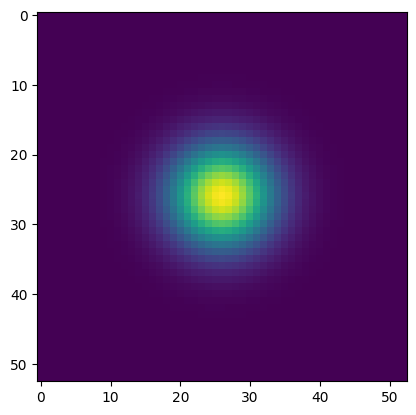

In [15]:
plt.imshow(target_images[0])

In [9]:
draw_params

{'e1': Array([ 2.24264526e-05, -1.02100921e-04,  3.45826107e-04,  3.92064267e-04,
         8.80157091e-04], dtype=float64),
 'e2': Array([-3.78557538e-05,  1.90345726e-04,  7.85219572e-04,  2.61011598e-04,
         5.13504208e-04], dtype=float64),
 'g1': Array([0.02, 0.02, 0.02, 0.02, 0.02], dtype=float64, weak_type=True),
 'g2': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 'hlr': Array([1., 1., 1., 1., 1.], dtype=float64, weak_type=True),
 'x': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 'y': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 'f': Array([1000000., 1000000., 1000000., 1000000., 1000000.],      dtype=float64, weak_type=True)}

In [10]:
# finally, interim samples are on 'sheared ellipticity'
_get_true_params = vmap(get_true_params_from_galaxy_params)
true_params = _get_true_params(galaxy_params)
true_params

{'e1': Array([0.02002242, 0.01989794, 0.0203457 , 0.02039191, 0.02087979],      dtype=float64),
 'e2': Array([-3.78405776e-05,  1.90270365e-04,  7.84894626e-04,  2.60903101e-04,
         5.13280735e-04], dtype=float64),
 'hlr': Array([1., 1., 1., 1., 1.], dtype=float64, weak_type=True),
 'lf': Array([6., 6., 6., 6., 6.], dtype=float64, weak_type=True),
 'x': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True),
 'y': Array([0., 0., 0., 0., 0.], dtype=float64, weak_type=True)}

In [16]:
gkeys = random.split(gkey, n_gals)
pipe = partial(
    pipeline_image_interim_samples_one_galaxy,
    initialization_fnc=INIT_FNC,
    sigma_e_int=sigma_e_int,
    n_samples=n_samples_per_gal,
    initial_step_size=initial_step_size,
    slen=slen,
    fft_size=fft_size,
    background=background,
)
vpipe = vmap(jjit(pipe), (0, 0, 0))

In [17]:
# compilation on single target image
_ = vpipe(
    gkeys[0, None],
    {k: v[0, None] for k, v in true_params.items()},
    target_images[0, None],
)

## Check samples from script run

In [26]:
import matplotlib.pyplot as plt 
from bpd.io import load_dataset
import jax.numpy as jnp

In [27]:
samples1 = load_dataset("/pscratch/sd/i/imendoza/data/cache_chains/interim_image_fix3/e_post_42.npz")

In [28]:
e_post = samples1['e_post'] 
e_post.shape

(500, 100, 2)

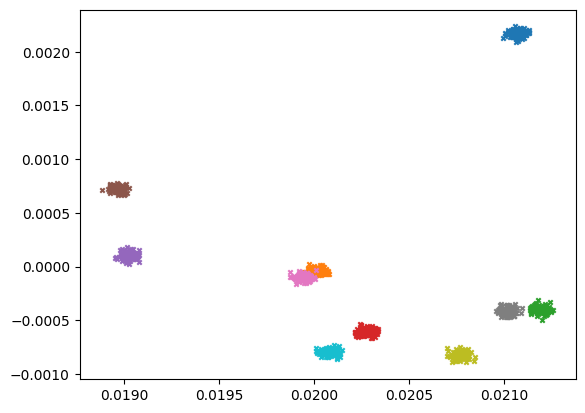

In [29]:
for ii in range(10, 20):
    plt.scatter(e_post[ii, :, 0], e_post[ii, :, 1], s=10, marker='x')

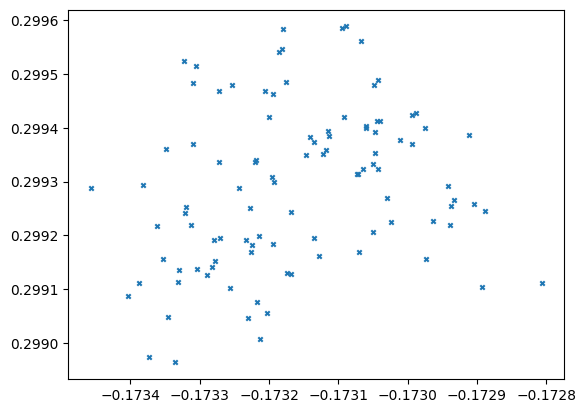

In [36]:
plt.scatter(samples1['xy'][2, :, 0], samples1['xy'][2, :, 1], s=10, marker='x') # exteremly precise

In [32]:
g_samples = jnp.load("/pscratch/sd/i/imendoza/data/cache_chains/interim_image_fix3/g_samples_42_42.npy")
g_samples.shape

(3000, 2)

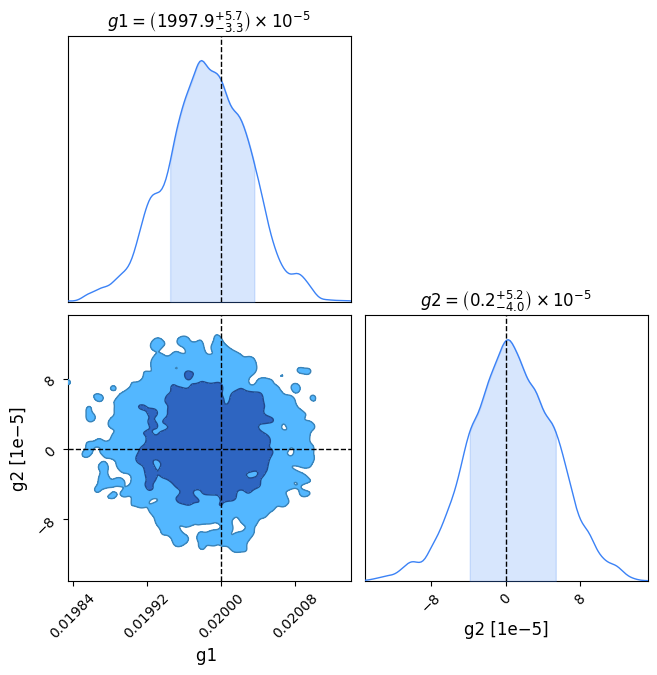

In [33]:
from bpd.diagnostics import get_contour_plot
gdict = {'g1': g_samples[:, 0], 'g2': g_samples[:, 1]}
truth = {'g1': 0.02, 'g2': 0.0}
_ = get_contour_plot([gdict], ['post'],  truth)


In [34]:
(g_samples[:, 0].mean() - 0.02) /0.02

Array(-0.00073676, dtype=float64)

In [35]:
g_samples[:, 0].mean()

Array(0.01998526, dtype=float64)